## Project Objective / Business Relevance

*Pseudomonas aeruginosa* frequently infects hospitalized patients and has high morbidity and mortality rates. With antibiotic resistance emerging as a major problem in effective *P. aeruginosa* treatment, innovative testing methods are in high-demand to better inform drug prescriptions. 

The aim of this project is to build a classification model to accurately predict the susceptiblity of *P. aeruginosa* isolates to the commonly-used drug tobramycin. The model will be trained using *orfN* gene sequences, a gene which has been shown to mutate first to convey tobramycin resistance in this pathogen.

This model will hopefully serve as the basis for a rapid anti-microbial susceptibility testing method (AST). Using only one type of gene means significantly less data will be required compared to other proposed methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

## Importing and Cleaning Data

Data will be obtained from two different sources. 

1. The *orfN* gene sequence data for each isolate was obtained from the BV-BRC database using the reference sequence locus tag “PA14_23460”: https://www.bv-brc.org/view/Feature/PATRIC.208963.12.NC_008463.CDS.2040149.2041165.fwd

2. The tobramycin resistance phenotype data was obtained from the “Dataset EV1” file in Khaledi et al. (2020):https://www.embopress.org/doi/full/10.15252/emmm.201910264

In [3]:
# Importing gene sequence data
seq_df = pd.read_csv('/Users/graham/Projects/Antibiotic Resistance Prediction/Datasets/BV-BRC_Allstrains.csv', 
                     usecols=[3, 11])
seq_df

,Isolate,Length
0,CF592_Iso2,1026
1,CF609_Iso3,1041
2,CH2500,1017
3,CH2527,1026
4,CH2543,1026
...,...,...
374,ZG5089456,1020
375,ZG8006959,1026
376,ZG8038581181,885
377,ZG8510487,1020


In [4]:
# Importing resistance phenotype data; only importing parts of excel sheet that are needed
phen_df = pd.read_csv('/Users/graham/Projects/Antibiotic Resistance Prediction/Datasets/BactomeResistanceData.csv', 
                      usecols=[0, 2], nrows=377)
phen_df

,Isolate,TOB
0,CF592_Iso2,S
1,CF609_Iso3,I
2,CH2500,S
3,CH2527,S
4,CH2543,R
...,...,...
370,ZG5089456,R
371,ZG8006959,R
372,ZG8038581181,R
373,ZG8510487,R


The datasets are cross-referenced to see for which isolates we have both types of data.

In [5]:
# Dropping extra isolates from seq_df
filt = seq_df['Isolate'].isin(phen_df['Isolate'])
to_drop = seq_df[filt == False]
seq_df.drop(to_drop.index, axis=0, inplace=True)
seq_df

,Isolate,Length
0,CF592_Iso2,1026
1,CF609_Iso3,1041
2,CH2500,1017
3,CH2527,1026
4,CH2543,1026
...,...,...
374,ZG5089456,1020
375,ZG8006959,1026
376,ZG8038581181,885
377,ZG8510487,1020


There are 4 isolates in the seq_df dataframe that we do not have phenotype data for. These isolates are dropped.

The isolates with “intermediate” susceptibility to tobramycin are dropped to broaden the gap between resistant and susceptible isolates.

In [6]:
# Dropping isolates with I from phen_df
i_to_drop = phen_df[phen_df['TOB'] == 'I']
phen_df.drop(i_to_drop.index, axis=0, inplace=True)

# Dropping corresponding isolates from seq_df
i_filter = seq_df['Isolate'].isin(i_to_drop['Isolate'])
seq_df = seq_df[~i_filter]

assert len(phen_df) == len(seq_df)

Outliers for sequence legnth limits are determined using the IQR method.

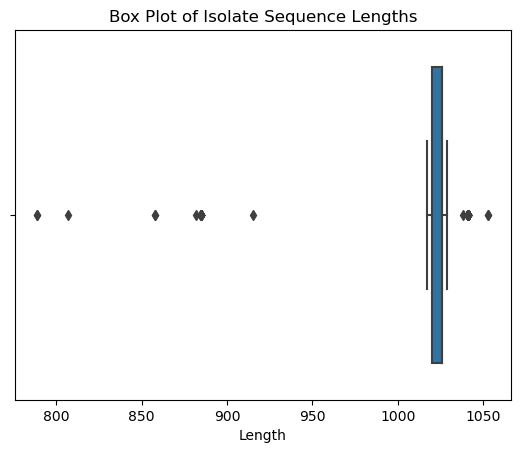

In [7]:
# Plotting box plot of sequence lengths
sns.boxplot(data=seq_df, x='Length')
palette = sns.color_palette('Set2')
sns.set_palette(palette)
plt.title("Box Plot of Isolate Sequence Lengths")
plt.show()

In [8]:
seq_df.describe()

,Length
count,367.000000
mean,1014.065395
std,44.896007
min,789.000000
25%,1020.000000
50%,1026.000000
75%,1026.000000
max,1053.000000


From the box plot and the dataframe above, it can be seen that several outliers exist. Some are well below the boxplot whiskers with the lowest at 612 and others are just above the boxplot whiskers. 

In [9]:
# Determining outliers
Q1 = seq_df['Length'].quantile(0.25)
Q3 = seq_df['Length'].quantile(0.75)
IQR = Q3 - Q1
outliers_filter = (seq_df['Length'] < (Q1 - 1.5 * IQR)) | (seq_df['Length'] > (Q3 + 1.5 * IQR))
outliers = seq_df[outliers_filter]
outliers['Length'].unique()
print(f"There are {len(outliers)} outliers.")

There are 113 outliers.


**We can see above that 113 outliers is a large portion of our dataset. In this case, removing outliers would mean training our model on a small range of sequence lengths. This would likely improve model performance but would make the model less generalizable to real-world scenarios where the sequence length can vary significantly.**

**In order to build a model that performs well on a large range of sequence lengths (which best represents real-world conditions), these outliers will be kept in our dataset.**

In [10]:
print(f"Length of phen_df: {len(phen_df)}, length of seq_df: {len(seq_df)}")

Length of phen_df: 367, length of seq_df: 367


This cleaning has left us with 367 isolates. The next step is to use multiple sequence alignment (MSA) using the BV-BRC website. This technique uses the “Mafft” aligner to align the isolate gene sequences as best as possible relative to the PA14 reference *orfN* sequence taken from the Pseudomonas Genome Database: https://www.pseudomonas.com/feature/show/?id=1654623&view=sequence

In [11]:
from Bio import AlignIO
# Load MSA file in FASTA format
msa = AlignIO.read('/Users/graham/Projects/Antibiotic Resistance Prediction/BVBRC_msa_refPA14.fasta', 'fasta')
msa

<<class 'Bio.Align.MultipleSeqAlignment'> instance (369 records of length 1073) at 11acaf310>

In [12]:
# Create a dataframe for msa
msa_df = pd.DataFrame()
# Add sequences from msa to dataframe
for i, record in enumerate(msa):
    msa_df[i] = list(record.seq)
# Flip rows and columns
msa_df = msa_df.transpose()
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [13]:
# Missing values are in present as '-' 
msa_df.replace('-', np.nan, inplace=True)

In [14]:
# Determining # columns with missing values
na_columns = msa_df.columns[msa_df.isnull().any()]
num_na_columns = len(na_columns)
print(f"There are {num_na_columns} columns with missing values.")

There are 512 columns with missing values.


Although this represents just under half of the features in our dataset, there are still a large number of features for the models to learn from even after dropping these. This also narrows down the features to those that are common across all of the sequence lengths.

In [15]:
# Dropping columns with missing values
msa_df = msa_df.dropna(axis=1)
# Ensuring columns have been dropped
na_columns = msa_df.columns[msa_df.isnull().any()]
num_na_columns = len(na_columns)
print(f"There are {num_na_columns} columns with missing values.")

There are 0 columns with missing values.


In [16]:
# Set the index labels to the BRC ID's for each isolate
msa_df.index = [rec.id for rec in msa]
msa_df.replace('|', ':', inplace=True)
msa_df

,234,235,236,237,238,239,240,241,242,243,...,816,817,818,819,820,821,822,823,824,825
reference_seq,G,C,T,A,G,G,T,G,C,T,...,A,A,G,T,C,T,A,C,G,A
fig:287.12739.peg.662,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
fig:287.12529.peg.1653,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
fig:287.12511.peg.818,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
fig:287.12550.peg.1478,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fig:287.12728.peg.1837,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
fig:287.12488.peg.43,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
fig:287.12507.peg.1222,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
fig:287.12497.peg.3325,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a


In [17]:
# Importing dataframe with corresponding BRC-ID's and strain names
mapping_df = pd.read_csv('/Users/graham/Projects/Antibiotic Resistance Prediction/Datasets/BV-BRC ID Data.csv', 
                         usecols=['Strain', 'BRC ID', 'Length'])
# Creating dictionnary that maps BRC ID's to strain names
mapping_dict = dict(zip(mapping_df['BRC ID'], mapping_df['Strain']))
# Rename msa_df index with mapping dictionnary
msa_df.index = msa_df.index.map(mapping_dict)
msa_df

,234,235,236,237,238,239,240,241,242,243,...,816,817,818,819,820,821,822,823,824,825
Reference PA14,G,C,T,A,G,G,T,G,C,T,...,A,A,G,T,C,T,A,C,G,A
PSAE1984,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
ZG205565,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
MHH17441,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
ZG8006959,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP084,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
CH5363,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
CH5695,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
CH5548,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a


In [18]:
# Dropping reference PA14 strain rows
msa_df = msa_df.drop(['Reference PA14', 'UCBPP-PA14'])
msa_df

,234,235,236,237,238,239,240,241,242,243,...,816,817,818,819,820,821,822,823,824,825
PSAE1984,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
ZG205565,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
MHH17441,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
ZG8006959,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
ZG5021922,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP084,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a
CH5363,g,c,t,g,g,g,t,g,c,a,...,a,a,t,t,c,t,a,t,g,a
CH5695,a,c,t,t,c,t,c,g,c,t,...,a,g,g,t,g,t,a,t,g,a
CH5548,c,c,t,g,g,g,g,g,c,g,...,a,g,g,t,t,t,a,t,g,a


In [19]:
# Changing nucleotides to upper case
msa_df = msa_df.apply(lambda x: x.str.upper())
msa_df.head(2)

,234,235,236,237,238,239,240,241,242,243,...,816,817,818,819,820,821,822,823,824,825
PSAE1984,C,C,T,G,G,G,G,G,C,G,...,A,G,G,T,T,T,A,T,G,A
ZG205565,G,C,T,G,G,G,T,G,C,A,...,A,A,T,T,C,T,A,T,G,A


In [20]:
# Looking at how many different nucleotides occur at each position
describe_df = msa_df.describe()
describe_df

,234,235,236,237,238,239,240,241,242,243,...,816,817,818,819,820,821,822,823,824,825
count,367,367,367,367,367,367,367,367,367,367,...,367,367,367,367,367,367,367,367,367,367
unique,4,2,1,4,2,2,3,1,2,4,...,2,3,3,1,4,2,1,2,2,1
top,A,C,T,G,G,G,G,G,C,G,...,A,G,G,T,T,T,A,T,G,A
freq,157,278,367,129,233,233,190,367,286,131,...,307,222,239,367,167,335,367,321,338,367


In [21]:
# Filter df for columns where nucleotides are constant for all isolates
constant_col = describe_df.loc['unique', describe_df.loc['unique'] == 1]
cols_to_drop = constant_col.index.tolist()

In [22]:
# Constant columns are dropped - will not contribute to model learning
msa_df.drop(cols_to_drop, axis=1, inplace=True)
msa_df.shape

(367, 363)

The susceptibility labels ('S' or 'R') will now be added for each isolate

In [23]:
# Importing phenotype data
phenotype_df = pd.read_excel('/Users/graham/Projects/Antibiotic Resistance Prediction/Datasets/IsolatePhenotypes.xlsx', 
                             index_col=0)
# Merge phenotype dataframe with original MSA dataframe on isolate name (index) columns
msa_df = msa_df.merge(phenotype_df, left_index=True, right_index=True)
msa_df

,234,235,237,238,239,240,242,243,246,247,...,814,815,816,817,818,820,821,823,824,Phenotype
PSAE1984,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,S
ZG205565,G,C,G,G,G,T,C,A,T,T,...,G,A,A,A,T,C,T,T,G,S
MHH17441,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
ZG8006959,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
ZG5021922,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP084,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,R
CH5363,G,C,G,G,G,T,C,A,T,T,...,G,A,A,A,T,C,T,T,G,S
CH5695,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
CH5548,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,S


## Data Exploration

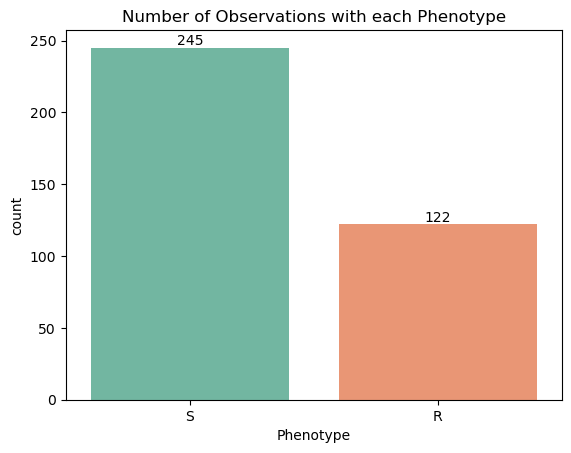

In [24]:
# Plotting counts for each phenotype
ax = sns.countplot(data=msa_df, x='Phenotype', palette='Set2')
# Adding count labels to bars
counts = msa_df['Phenotype'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=counts)
plt.title("Number of Observations with each Phenotype")
plt.show()

In [25]:
# Separating isolates into two dataframes based on susceptibility
res_df = msa_df[msa_df['Phenotype'] == 'R']
res_df.drop('Phenotype', axis=1, inplace=True)
sus_df = msa_df[msa_df['Phenotype'] == 'S']
sus_df.drop('Phenotype', axis=1, inplace=True)
print(f"There are {len(res_df)} resistant isolates and {len(sus_df)} susceptible isolates.")

There are 122 resistant isolates and 245 susceptible isolates.


**This imbalance between resistant and susceptible isolates is important to note. This will be accounted for later in model development. For now, the frequencies of each nucleotide will be normalized to get a proportion so the nuc frequency in resistant isolates can be fairly compared to the nuc frequency in susceptible isolates.**

In [26]:
# Creating dataframe for nucleotide frequencies (one for susceptible one for resistant isolates)
dfs = [res_df, sus_df]
nuc_freq_dfs = []
for df in dfs:    
    # Making a list that contains nucleotides for each sequence
    sequences = []
    for i in df.index:
        seq_list = df.loc[i, :].values.tolist()
        sequences.append(seq_list)

    # sequences is now a list of lists, convert to list of strings
    sequences = [''.join(sequence) for sequence in sequences]

    # Creating daframe for nucleotide frequencies
    frequencies = []
    for i in range(len(sequences[0])):
        counts = {'A': 0, 'T': 0, 'G': 0, 'C': 0}
        for sequence in sequences:
            counts[sequence[i]] += 1
        frequencies.append(counts)

    df_freq = pd.DataFrame(frequencies, index=df.columns)
    df_freq.index.names = ['Position']
    df_freq.columns = ['A', 'T', 'G', 'C']
    nuc_freq_dfs.append(df_freq)

In [27]:
# Assigning dataframes to res and sus
res_nuc_freq = nuc_freq_dfs[0]
sus_nuc_freq = nuc_freq_dfs[1]
# Turning rows into proportion of total nucleotides
res_nuc_prop = res_nuc_freq.div(res_nuc_freq.sum(axis=1), axis=0)
sus_nuc_prop = sus_nuc_freq.div(sus_nuc_freq.sum(axis=1), axis=0)

In [28]:
# Adding phenotype column to each df
res_nuc_prop['Phenotype'] = 'R'
sus_nuc_prop['Phenotype'] = 'S'
# Combining df's for better visualization
combined_df = pd.concat([res_nuc_prop, sus_nuc_prop])
combined_df
# Melting df to allow visualization
melted_df = pd.melt(combined_df, id_vars=['Phenotype'], value_vars=['A', 'T', 'G', 'C'], var_name='Nucleotide',
                   value_name='Proportion')

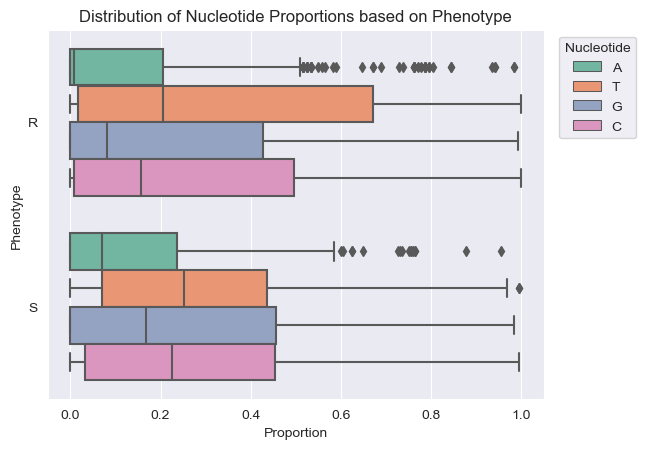

In [29]:
# Visualize distribution of nucelotides
sns.set_style('darkgrid')
sns.set_palette('tab10')
sns.boxplot(data=melted_df, y='Phenotype', x='Proportion', hue='Nucleotide', palette='Set2')
plt.legend(title='Nucleotide', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("Distribution of Nucleotide Proportions based on Phenotype")
plt.show()

From the box plot above, it can be seen that the distribution of nucleotide proportions between resistant and
susceptible isolates are similar. The IQR for T for resistant phenotypes is much larger than for susceptible ones, even though the median is higher for the latter.

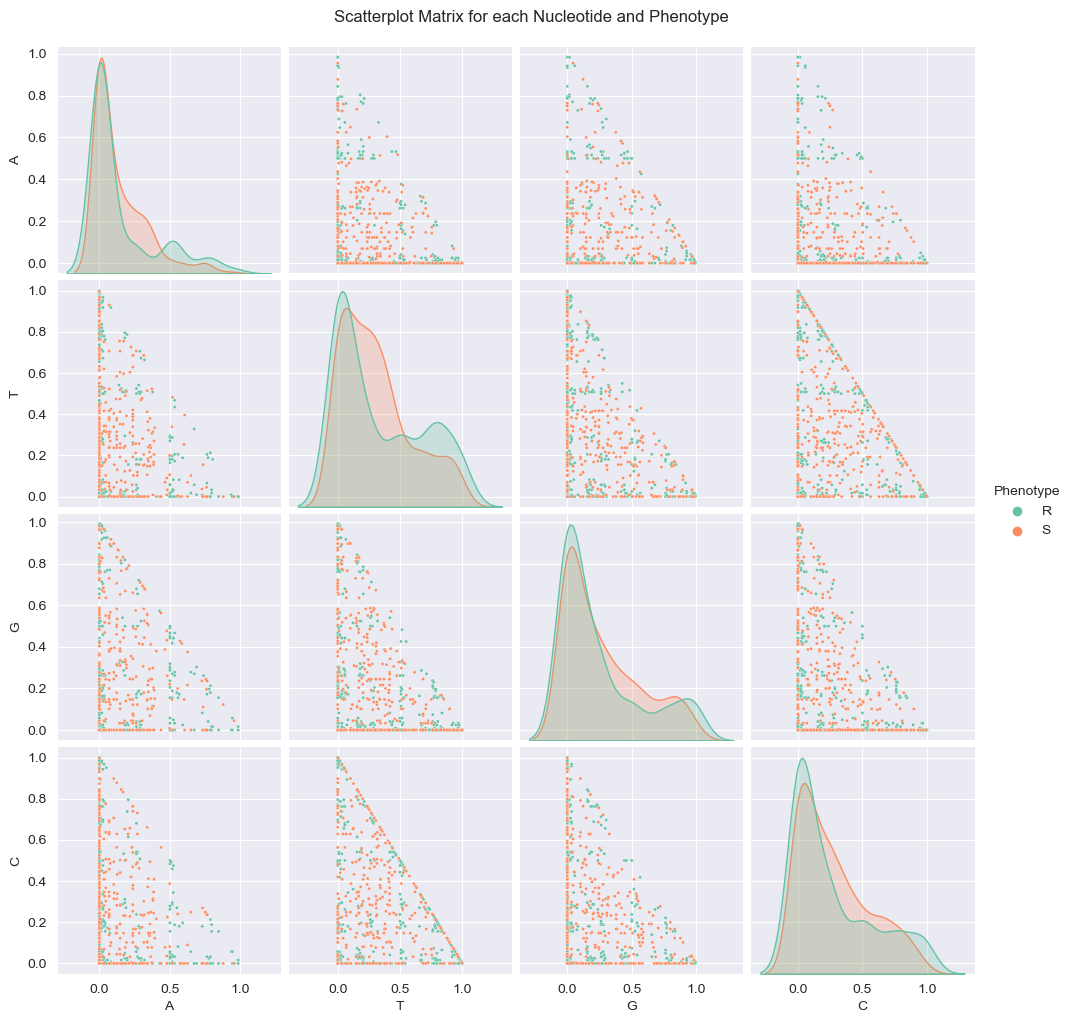

In [30]:
# A scatterplot matrix for each nucleotide and highlighted phenotypes
p = sns.pairplot(data=combined_df, vars=['A', 'T', 'G', 'C'], kind='scatter', hue='Phenotype', plot_kws={'s':5},
            palette='Set2')
p.fig.suptitle("Scatterplot Matrix for each Nucleotide and Phenotype", y=1.02)
plt.show()

The scatterplot matrix above shows that there are no commonly repeated major differences between nucleotide 
proportions for different phenotypes.

## Feature Preparation

The current categorical features should be converted to numerical values to achieve the best performance using a variety of models. For the target phenotypes this is simply converting 'S' and 'R' to 0 and 1 respectively.

To convert the features a few options exist. One option is to convert each letter to a corresping number (e.g. A:1, T:2, C:3, G:4). This is likely suitable although the magnitude of the numbers implies a false closeness of values. For example, a value of 1 is closer to 2 than 3 however an A nucleotide is no closer to T than to C.

***To avoid this, the categorical nucleotides can be encoded into dummy variables. This will result in an example sequence of 'ACGT' being converted into an array of the form [[1. 0. 0. 0.] [0. 1. 0. 0.] [0. 0. 1. 0.] [0. 0. 0. 1.]]. This may make interpreting the results slightly harder but we will see.

In [31]:
msa_df

,234,235,237,238,239,240,242,243,246,247,...,814,815,816,817,818,820,821,823,824,Phenotype
PSAE1984,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,S
ZG205565,G,C,G,G,G,T,C,A,T,T,...,G,A,A,A,T,C,T,T,G,S
MHH17441,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
ZG8006959,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
ZG5021922,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP084,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,R
CH5363,G,C,G,G,G,T,C,A,T,T,...,G,A,A,A,T,C,T,T,G,S
CH5695,A,C,T,C,T,C,C,T,C,G,...,C,A,A,G,G,G,T,T,G,R
CH5548,C,C,G,G,G,G,C,G,T,A,...,C,A,A,G,G,T,T,T,G,S


In [32]:
# Converting phenotype column to numerical 0 and 1
msa_df['Phenotype'] = msa_df['Phenotype'].replace({'S': 0, 'R': 1})
msa_df['Phenotype'].value_counts()

Phenotype
0    245
1    122
Name: count, dtype: int64

In [33]:
# Converting categorical data into dummy variables
num_data = pd.get_dummies(msa_df, drop_first=True, dtype=int)
num_data

,Phenotype,234_C,234_G,234_T,235_T,237_C,237_G,237_T,238_G,239_T,...,817_C,817_G,818_G,818_T,820_C,820_G,820_T,821_T,823_T,824_G
PSAE1984,0,1,0,0,0,0,1,0,1,0,...,0,1,1,0,0,0,1,1,1,1
ZG205565,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,1,0,0,1,1,1
MHH17441,1,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,1,1,1
ZG8006959,1,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,1,1,1
ZG5021922,1,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP084,1,1,0,0,0,0,1,0,1,0,...,0,1,1,0,0,0,1,1,1,1
CH5363,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,1,0,0,1,1,1
CH5695,1,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,1,1,1
CH5548,0,1,0,0,0,0,1,0,1,0,...,0,1,1,0,0,0,1,1,1,1


### PCA

In [34]:
# Performing PCA on the dummy variable matrix to extract the main sources of variance
from sklearn.decomposition import PCA
pca_df = num_data.iloc[:, 1:]
pca = PCA(n_components=10, random_state=42)
reduced = pca.fit(pca_df)
reduced.explained_variance_ratio_

array([0.31123286, 0.19876381, 0.14708264, 0.12539576, 0.10467701,
       0.05561147, 0.035087  , 0.00772009, 0.00667593, 0.00216681])

From the principal components above, we can see that roughly 7 components explain 98% of the variance.

In [35]:
# Keeping only 7 principal components
pca_df = num_data.iloc[:, 1:]
pca = PCA(n_components=7, random_state=42)
reduced_array = pca.fit_transform(pca_df)
reduced_df = pd.DataFrame(reduced_array, index=pca_df.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
reduced_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
PSAE1984,-7.655074,-6.376595,-1.610523,0.303328,-0.794406,-0.358077,-0.255759
ZG205565,-0.769597,2.288523,8.950275,-4.115427,-4.599834,-1.608354,-0.209353
MHH17441,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152
ZG8006959,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152
ZG5021922,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152
...,...,...,...,...,...,...,...
ESP084,-7.655074,-6.376595,-1.610523,0.303328,-0.794406,-0.358077,-0.255759
CH5363,-0.769597,2.288523,8.950275,-4.115427,-4.599834,-1.608354,-0.209353
CH5695,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152
CH5548,-7.655074,-6.376595,-1.610523,0.303328,-0.794406,-0.358077,-0.255759


In [36]:
# Adding the phenotype column that was removed for PCA
reduced_data = reduced_df.merge(phenotype_df, left_index=True, right_index=True)
reduced_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Phenotype
PSAE1984,-7.655074,-6.376595,-1.610523,0.303328,-0.794406,-0.358077,-0.255759,S
ZG205565,-0.769597,2.288523,8.950275,-4.115427,-4.599834,-1.608354,-0.209353,S
MHH17441,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152,R
ZG8006959,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152,R
ZG5021922,8.754510,-2.311616,-2.483853,-1.947525,-0.301324,-0.243536,-0.112152,R


In [37]:
# Separating data into X and y
y = reduced_data.iloc[:, -1]
X = reduced_data.iloc[:, :-1]
# Converting y column to numerical 0 and 1
y = y.replace({'S': 0, 'R': 1})
y.value_counts()
from sklearn.model_selection import train_test_split
# Separating data into train and test sets, stratify is not necessary because of oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70, stratify=y, shuffle=True)

In [38]:
# from imblearn.over_sampling import SMOTE
# # Oversampling is used to fix the major class imbalance
# over_sampling = SMOTE(random_state=50)
# X, y = over_sampling.fit_resample(X, y)
# # Both classes now have 245 instances
# X.shape

In [39]:
# Verifying X and y are in correct numerical format
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, CH2680 to F1968
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     293 non-null    float64
 1   PC2     293 non-null    float64
 2   PC3     293 non-null    float64
 3   PC4     293 non-null    float64
 4   PC5     293 non-null    float64
 5   PC6     293 non-null    float64
 6   PC7     293 non-null    float64
dtypes: float64(7)
memory usage: 18.3+ KB


In [40]:
y_train.isna().any()

False

In [41]:
y_train

CH2680       0
F2208        1
ZG8525123    1
M70565897    0
PSAE1656     0
            ..
F1979        1
F2234        0
PSAE1401     0
M70640096    0
F1968        0
Name: Phenotype, Length: 293, dtype: int64

## Modeling

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#### Flase negatives and false positives  are interpreted in the context of our real world problem below:

#### False negatives (FN): the bacteria is resistant to tobramycin but falsely classified as susceptible. Could lead to prescription of tobramycin leading to negative patient outcome.

#### False positive (FP): the bacteria is susceptible to tobramycin but falsely classififed as resistant. Could to prescription of other antibiotic that is less effective when tobramycin would have worked - negative patient outcome.

#### From these examples, we can see that minimizing both FN and FP are important. However, the FN case where tobramycin is used to treat a tobramycin-resistant isolate is objectively a significantly worse outcome than the FP scenario. 

#### For this reason we will use recall as the main performance metric to maximize during model building. Maximizing recall minimizes FN instances.

Note the importance of FP and FN should be confirmed with knowledgable physicians to determine the most important clinical metrics.

In [43]:
# Cross validation for 5 different models
# max iterations are adjusted so solvers converge
models = {'random_forest': RandomForestClassifier(), 'logistic_regression': LogisticRegression(max_iter=500), 'supper_vector_machine':
         SVC(), 'linear_supper_vector_machine': LinearSVC(max_iter=10000), 'KNN': KNeighborsClassifier()}
cv_means=[]
cv_errors=[]
for model in models.values():
    # 5-fold cross-validation
    # Ensure stratified to keep consistent percentage of each class across fold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=70)
    cv_recall = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
    # appending scores from cross-val for each model to the list of results
    cv_means.append(cv_recall.mean())
    cv_errors.append(cv_recall.std() / np.sqrt(5))

In [44]:
# Rounding means and std errors
cv_means = [round(num, 2) for num in cv_means]
cv_errors = [round(num, 2) for num in cv_errors]
# Calculating confidence interval for standard error
CI = [std_err * 1.96 for std_err in cv_errors]
CI = [round(num, 2) for num in CI]
cv_df = pd.DataFrame({"Model": models.keys(), 'Cross Val Mean Recall': cv_means, 'Std Error': cv_errors, '95% Confidence interval': 
                      CI})
cv_df

,Model,Cross Val Mean Recall,Std Error,95% Confidence interval
0,random_forest,0.75,0.02,0.04
1,logistic_regression,0.75,0.02,0.04
2,supper_vector_machine,0.75,0.02,0.04
3,linear_supper_vector_machine,0.75,0.02,0.04
4,KNN,0.65,0.07,0.14


In [45]:
# Displaying mean for each classifier
cv_means

[0.75, 0.75, 0.75, 0.75, 0.65]

In [46]:
# Evaluating performance on test set
from sklearn.metrics import recall_score
test_results=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall_test = recall_score(y_test, y_pred)
    test_results.append(recall_test)
# Displaying results in dataframe
test_df = pd.DataFrame({"Model": models.keys(), "Test Recall": test_results})
test_df

,Model,Test Recall
0,random_forest,0.8
1,logistic_regression,0.8
2,supper_vector_machine,0.8
3,linear_supper_vector_machine,0.8
4,KNN,0.8


In [47]:
# function that returns indices of wrong predictions
def wrong_indices(y_pred):
    indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
    return indices

In [48]:
from sklearn.metrics import confusion_matrix
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Displaying confusion matrix for each model
    con_matrix = confusion_matrix(y_test, y_pred)
    print(f'{name} confusion matrix: {con_matrix}')
    # Displaying isolates predicted incorrectly by each model    
    wrong_predictions = wrong_indices(y_pred)
    print(f'{name} incorrect predictions: {wrong_predictions}')

random_forest confusion matrix: [[42  7]
 [ 5 20]]
random_forest incorrect predictions: [0, 2, 20, 31, 33, 35, 42, 45, 49, 50, 51, 71]
logistic_regression confusion matrix: [[42  7]
 [ 5 20]]
logistic_regression incorrect predictions: [0, 2, 20, 31, 33, 35, 42, 43, 45, 50, 51, 71]
supper_vector_machine confusion matrix: [[42  7]
 [ 5 20]]
supper_vector_machine incorrect predictions: [0, 2, 20, 31, 33, 35, 42, 43, 45, 50, 51, 71]
linear_supper_vector_machine confusion matrix: [[42  7]
 [ 5 20]]
linear_supper_vector_machine incorrect predictions: [0, 2, 20, 31, 33, 35, 42, 43, 45, 50, 51, 71]
KNN confusion matrix: [[43  6]
 [ 5 20]]
KNN incorrect predictions: [0, 2, 20, 31, 33, 35, 42, 45, 50, 51, 71]


It can be seen every model makes the same incorrect predictions except the KNN makes one more correct prediction than the other.

The precision-recall curves will be plotted for each classifier. This is relevant to this scenario where we are more interested in the resistant class than the susceptible class and because our dataset has a large imbalance. These curves allow us to identify an optimal threshold value where the model has high recall (our primary metric) while still obtaining reasonably high precision (not primary but still relevant). 

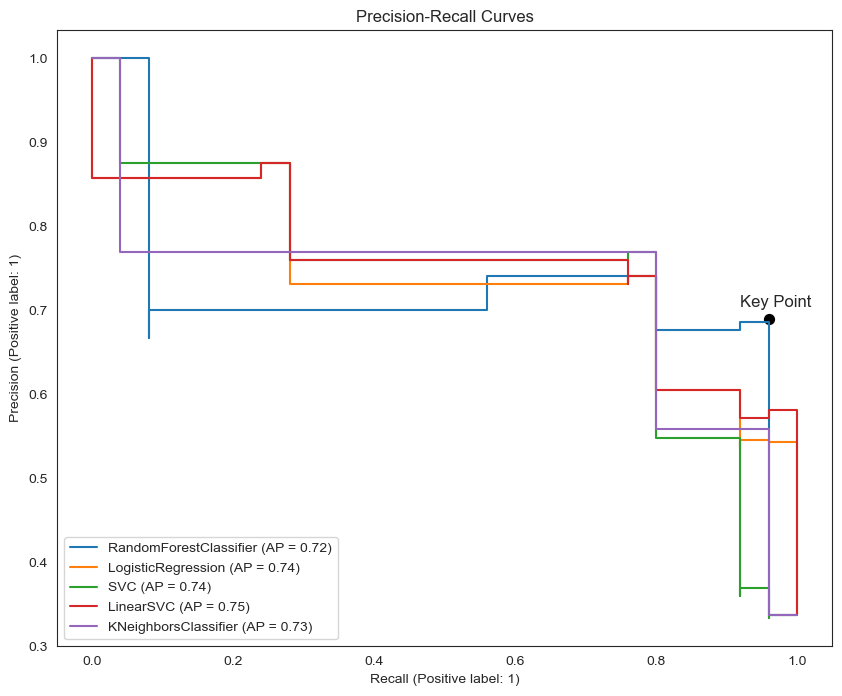

In [61]:
# Plotting precision-recall curves for each classifier
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(figsize=(10, 8))
for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=plt.gca())
    
# Labeling key point
plt.scatter(0.96, 0.69, color='black', marker='o', s=50, label='Specific Point')
plt.text(1.02, 0.7, 'Key Point', fontsize=12, ha='right', va='bottom')

plt.title("Precision-Recall Curves")
plt.show()

From the plot above, we can see that the random forest classifier (blue) achieves a high recall of around 0.95 while maintaining a reasonable precision of around 0.67 at the key point highlighted. This is the highest recall possible without a signficant decrease in precision.

Model optimization and hyperparameter tuning will now be done with the random forest classifier.

In [50]:
# Conducting grid search to optiminze key hyperparameters for random forest model
from sklearn.model_selection import GridSearchCV
# l2 is the only penalty that works with all solvers so penalty will not be searched
params = {'n_estimators':[100, 250, 500], 'max_features':["sqrt", "log2", None], 'min_samples_leaf':[1, 10, 50], 'max_depth':[None, 5, 20]}
rf = RandomForestClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=70)
grid_search = GridSearchCV(rf, param_grid=params, scoring='recall', cv=kf, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}, recall: {grid_search.best_score_}")

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}, recall: 0.7515789473684211


From the grid search above, it can be seen that the 'optimal' hyperparamers achieve the same recall score as the default parameters. The default parameters (with max iterations as 500) will be used for the final model.

In [51]:
# Saving optimized rf model
rf_final = grid_search.best_estimator_
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

In [52]:
# Calculating predicted probabilities with final model
pred_probs = rf_final.predict_proba(X_test)

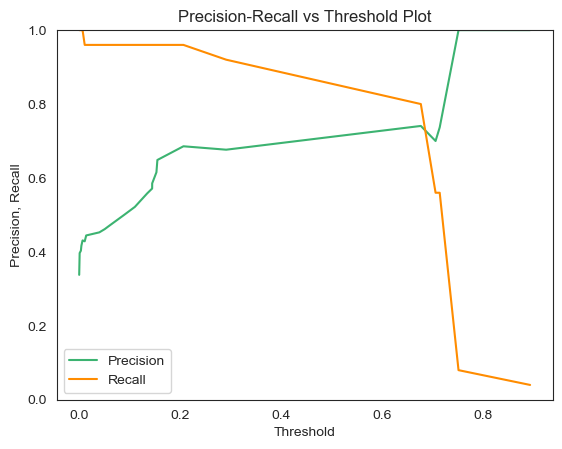

In [53]:
# Plotting precision and recall vs threshold values
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
sns.set_style('white')
precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 
1]) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Plot")
plt.plot(thresholds, precision[: -1], "mediumseagreen", label="Precision")
plt.plot(thresholds, recall[: -1], "darkorange", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

In the plot above we can see that at a threshold value of around 0.16, the recall is over 0.95 while precision is still reasonable at over 0.65. We will determine this optimal threshold below.

In [54]:
# Searching plot index for desired threshold 
start_index=13
stop_index=18
for i in range(start_index, stop_index):
    print(f"Index {i}: Precision: {precision[i]}, Recall: {recall[i]}, Threshold: {thresholds[i]}")

Index 13: Precision: 0.5714285714285714, Recall: 0.96, Threshold: 0.14437455355372786
Index 14: Precision: 0.5853658536585366, Recall: 0.96, Threshold: 0.14443990898661194
Index 15: Precision: 0.6153846153846154, Recall: 0.96, Threshold: 0.15285289710289704
Index 16: Precision: 0.6486486486486487, Recall: 0.96, Threshold: 0.15474062049062046
Index 17: Precision: 0.6857142857142857, Recall: 0.96, Threshold: 0.2063080420318777


At an index of 16, the recall is 0.96 and the precision is 0.66. We will use the corresponding threshold value for our model to achieve a high recall.

In [55]:
# Defining new threshold condition for classiyfing isolates as 0 or 1
threshold = 0.15829131344518793
new_y_pred = [1 if pred_probs[i][1]> threshold else 0 for i in range(len(pred_probs))]
new_y_pred = pd.Series(new_y_pred)

In [56]:
recall_score(y_test, new_y_pred)

0.96

In [57]:
from sklearn.metrics import precision_score
precision_score(y_test, new_y_pred)

0.6857142857142857

In [58]:
from sklearn.metrics import classification_report
report = classification_report(y_test, new_y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.974359,0.775510,0.863636,49.000000
1,0.685714,0.960000,0.800000,25.000000
accuracy,0.837838,0.837838,0.837838,0.837838
macro avg,0.830037,0.867755,0.831818,74.000000
weighted avg,0.876844,0.837838,0.842138,74.000000


In [59]:
type(y_test)

pandas.core.series.Series

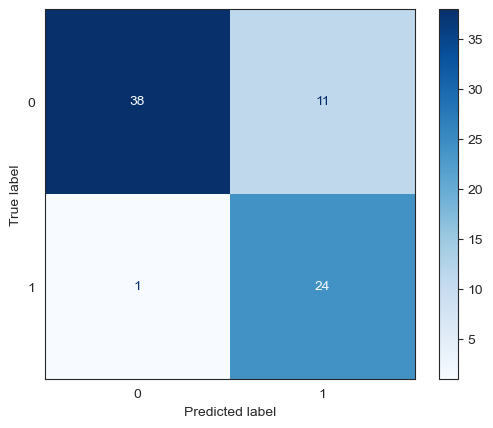

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_final = confusion_matrix(y_test, new_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=rf_final.classes_)
disp.plot(cmap=plt.cm.Blues)

As seen from the confusion matrix above, we now have less false negatives (improving recall) but more false positives (lower precision) and slightly lower overall accuracy. In this scneario this compromise is deemed acceptable since this will allow physicians to trust the results in the test knowing that it is unlikely they're prescribing tobramycin to resistant infections which is the worst case scenario we want to avoid.

## Conclusion

Utilizing PCA to reduce the feature dimensions from 685 to 7 didn't intially improve test or train recall values. However, it did improve the precision-recall curve for the random forest classifier which allowed turning the threshold to reach a recall of 0.96 instead of 0.92 without PCA. This resulted in the precision (for the positive class) to lower from 0.65 to 0.6, but this is an acceptable decrease for the increase in recall.

Possible improvements:
- conducting MSA with consensus as reference sequence OR not using a reference sequence
- investigating the sequences for the isolates which were predicted incorrectly for all classifiers. Determine what features/sequence
    patterns they have in common.
- look at the most important features for the PCA components that explain the most variance. This could give some insight into which gene positions contribute most to resistance.